# Axo ID tests
Notebook used to test detection and tracking together to start the work for AxoID.  
Workflow:
   1. Detection:
      1. Predict using deep network (generate detections)
      2. Decide if results are good:
         * Yes: continue to 2.
         * No: continue to 1.C
      3. Make manual annotations (to be done externally to this notebook)
      4. Fine tune the deep network (i.e., retrain it with manual annotations)
      5. Go to 1.B
   2. User correction (optional) (to be done externally to this notebook)
   3. Tracking:
      1. Select an initialization frame
      2. Track axons:
         * Train model
         * Generate final identities
   4. User correction (optional) (to be done externally to this notebook)

In [1]:
%matplotlib inline

import os, sys, time, shutil, copy, time
import re
import random
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, external, measure, morphology
from scipy import ndimage as ndi
from scipy import stats
import cv2
import imgaug.augmenters as iaa

import torch

from utils_common.image import imread_to_float, to_npint, overlay_preds_targets
from utils_common.metrics import dice_coef
from utils_common.register_cc import register_stack, shift_image
# Following are copy-pasted from other folders. Check that they are up-to-date
from utils_data import normalize_range, get_all_dataloaders, pad_transform, pad_transform_stack, compute_weights
from utils_finetuning import fine_tune, ROIAnnotator_mpl
from utils_loss import get_BCEWithLogits_loss
from utils_metric import get_dice_metric
from utils_model import CustomUNet, load_model
from utils_test import predict, predict_stack, evaluate, evaluate_stack
from internal_model import InternalModel
from utils_tracking import get_rules, rules_violated

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

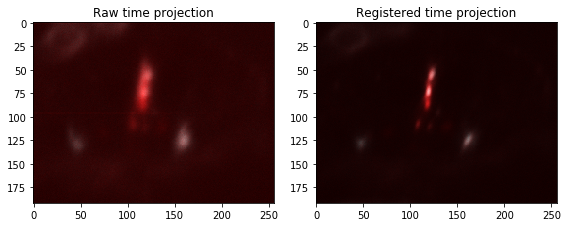

In [128]:
# Load experiment
experiment = "/data/talabot/experiments/to_annotate/SS29893_20190328_tdTomGC6fopt-fly3/SS29893_20190328_tdTomGC6fopt-fly3_003/"
ref_num = 1

rgb_stack = imread_to_float(os.path.join(experiment, "RGB.tif"))
if os.path.isfile(os.path.join(experiment, "seg_ROI.tif")):
    seg_stack = imread_to_float(os.path.join(experiment, "seg_ROI.tif"))
else:
    seg_stack = None
if os.path.isfile(os.path.join(experiment, "weights.tif")):
    weights_stack = imread_to_float(os.path.join(experiment, "weights.tif"))
else:
    weights_stack = None

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.suptitle(experiment)
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:
        plt.subplot(132)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    if weights_stack is not None:
        plt.subplot(133)
        plt.title("Pixel weighting")
        plt.imshow(weights_stack[image], cmap="gray")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Compute registration through cross-correlation
reg_rgb, reg_rows, reg_cols = register_stack(rgb_stack, ref_num=ref_num, return_shifts=True)
reg_rgb = reg_rgb.clip(0, 1)
if seg_stack is not None:
    reg_seg = np.zeros_like(seg_stack)
    for i in range(len(reg_seg)):
        reg_seg[i] = shift_image(seg_stack[i], reg_rows[i], reg_cols[i])
    reg_seg = reg_seg.clip(0, 1)
else:
    reg_seg = None

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Raw time projection")
plt.imshow(rgb_stack.mean(0) / rgb_stack.mean(0).max())
plt.subplot(122)
plt.title("Registered time projection")
plt.imshow(reg_rgb.mean(0) / reg_rgb.mean(0).max())
plt.tight_layout()
plt.show()

# 1. Detection
Detect ROIs on the frames as a binary segmentation

### A. Prediction
Load a model and predict over the experiments

In [70]:
model_name = "../detection/deep_learning/models/190401_sep_synth_aug/"
out_model_name = "../detection/deep_learning/models/test_axoid"

batch_size = 16

# Load model
input_channels = "RG" # Channels to use as input
u_depth = 4
out1_channels = 16
# model = CustomUNet(in_channels=len(input_channels), u_depth=u_depth, 
#                    out1_channels=out1_channels, device=device)
model = load_model(model_name, input_channels=input_channels, u_depth=u_depth, 
                   out1_channels=out1_channels, device=device)
metrics = {"dice": get_dice_metric()}
input_transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))
# Save future model
os.makedirs(out_model_name, exist_ok=True)
shutil.copy("utils_model.py", os.path.join(out_model_name, "utils_model_save.py"))
model_ft = copy.deepcopy(model)

Predicted experiment in 3.6 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

Computation of #ROIs took 0.2 s.
First occurences (except first frame): argmax = 97 - argmin = 24
17 frames with less than 4 ROIs


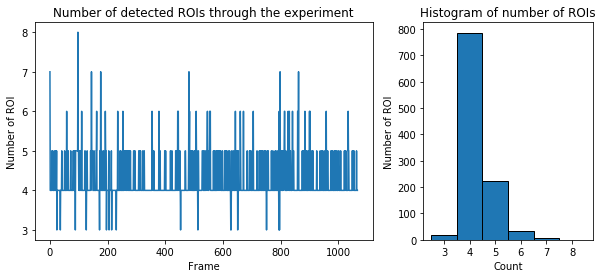

In [129]:
min_area = 16

# Predict and display results
start = time.time()
predictions = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels,
                            transform=input_transform)
predictions = torch.sigmoid(predictions)

detections = (predictions > 0.5).numpy().astype(np.bool)
for i in range(len(detections)):
    detections[i] = morphology.remove_small_objects(detections[i], min_area)
    
print("Predicted experiment in %.1f s." % (time.time() - start))
if seg_stack is not None:
    print("Dice =", dice_coef(detections, seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    plt.subplot(133)
    if seg_stack is not None:
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets(detections[image], seg_stack[image]))
    else:
        plt.title("Binary prediction")
        plt.imshow(detections[image])
    plt.tight_layout()
    plt.show()

start = time.time()
n_roi = np.zeros(len(rgb_stack), np.uint8)
for i in range(len(detections)):
    _, n = measure.label(detections[i], connectivity=1, return_num=True)
    n_roi[i] = n
print("Computation of #ROIs took %.1f s." % (time.time() - start))
print("First occurences (except first frame): argmax = %d - argmin = %d" % \
      (np.argmax(n_roi[1:]) + 1, np.argmin(n_roi[1:]) + 1))
print("%d frames with less than %d ROIs" % (np.sum(n_roi < stats.mode(n_roi)[0]), stats.mode(n_roi)[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [2, 1]})
ax1.set_title("Number of detected ROIs through the experiment")
ax1.plot(n_roi)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Number of ROI")
ax2.set_title("Histogram of number of ROIs")
ax2.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k')
ax2.set_xticks(np.arange(n_roi.min(), n_roi.max() + 1))
ax2.set_xlabel("Count")
ax2.set_ylabel("Number of ROI")
plt.show()

### C. Manual annotation
Create some manual annotations (outside this notebook), and fine tune the network with them.

In [94]:
# Select and annotated frames
n_train = 3 # number of frames to annotated for training
n_valid = 2 # number of frames to annotated for validation

# Randomly choose frames
indices = np.random.choice(np.arange(len(rgb_stack)), size=n_train + n_valid, replace=False)
idx_train = indices[:n_train]
idx_valid = indices[n_train:]
print("Indices of annotated frames:", idx_train, idx_valid, sep="\n")
rgb_train = np.stack([rgb_stack[idx] for idx in idx_train])
rgb_valid = np.stack([rgb_stack[idx] for idx in idx_valid])

# Save current segmentations to use in annotation
external.tifffile.imsave("/home/user/talabot/workdir/corrections.tif", 
                         to_npint(np.stack([detections[i] for i in np.concatenate([idx_train, idx_valid])])),
                         photometric="minisblack")

Indices of annotated frames:
[ 865  599 1042]
[420 557]


In [73]:
# Load manual annotations
seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
seg_train = seg_annotated[:n_train]
seg_valid = seg_annotated[n_train:]

In [102]:
# Manually add indices for annotation if annotation was not good enough
new_idx = np.random.choice(np.arange(len(n_roi))[n_roi < 4], size=5, replace=False)
new_idx_train = list(new_idx[:3])
new_idx_valid = list(new_idx[3:])

# Randomly choose frames
print("Indices of new annotated frames:", repr(new_idx), new_idx_train, new_idx_valid, sep="\n")
new_rgb_train = np.stack([rgb_stack[idx] for idx in new_idx_train])
new_rgb_valid = np.stack([rgb_stack[idx] for idx in new_idx_valid])

# Save current segmentations to use in annotation
external.tifffile.imsave("/home/user/talabot/workdir/corrections.tif", 
                         to_npint(np.stack([detections[i] for i in new_idx_train + new_idx_valid])),
                         photometric="minisblack")

Indices of new annotated frames:
array([831, 788, 366,  47, 182])
[831, 788, 366]
[47, 182]


In [103]:
# Load new manual annotations
new_seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
new_seg_train = new_seg_annotated[:len(new_idx_train)]
new_seg_valid = new_seg_annotated[len(new_idx_train):]

In [104]:
# Concatenate previous and new annotations
idx_train = np.concatenate([idx_train, new_idx_train])
idx_valid = np.concatenate([idx_valid, new_idx_valid])
rgb_train = np.concatenate([rgb_train, new_rgb_train])
rgb_valid = np.concatenate([rgb_valid, new_rgb_valid])
seg_train = np.concatenate([seg_train, new_seg_train])
seg_valid = np.concatenate([seg_valid, new_seg_valid])
print("Indices of annotated frames:", idx_train, idx_valid, sep="\n")

Indices of annotated frames:
[1006  218  648    0  858  679  310  293  491  224  678   53  487  302
  944  189  459   89  831  788  366]
[ 669  179  474 1017  299  462  223  640  783  731  644 1014   47  182]


### D. Fine tune the network

In [105]:
learning_rate = 0.0005
contour, separation = False, True

seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
weights_train = compute_weights(seg_train, contour=contour, separation=separation)
weights_valid = compute_weights(seg_valid, contour=contour, separation=separation)

@interact(image=(0, len(weights_train) + len(weights_valid) - 1))
def plot_experiment(image=0):
    if image < len(weights_train):
        rgb = rgb_train
        seg = seg_train
        wgt = weights_train
    else:
        rgb = rgb_valid
        seg = seg_valid
        wgt = weights_valid
    image %= len(weights_train)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg[image], cmap="gray")
    plt.subplot(133)
    plt.title("Pixel weighting")
    plt.imshow(wgt[image], vmax=max(wgt[image].max(), 0.1))
    plt.colorbar(fraction=0.035, pad=0.02)
    plt.tight_layout()
    plt.show()

start = time.time()
model_ft = fine_tune(model_ft, rgb_train, seg_train, weights_train, rgb_valid, seg_valid, 
                     data_aug=True, n_iter_min=0, n_iter_max=1000, patience=200,
                     batch_size=batch_size, learning_rate=learning_rate, verbose=1)
print("\nFine tuning took %.1f s." % (time.time() - start))

interactive(children=(IntSlider(value=0, description='image', max=34), Output()), _dom_classes=('widget-intera…

Initial val_dice = 0.874522
Iteration (min: 0 - max 1000): 
50: dice = 0.918039 - val_dice = 0.847389
100: dice = 0.922444 - val_dice = 0.851893
150: dice = 0.920753 - val_dice = 0.849252
200: dice = 0.913814 - val_dice = 0.837539
250: dice = 0.928364 - val_dice = 0.857233
300: dice = 0.922096 - val_dice = 0.847446
350: dice = 0.927758 - val_dice = 0.851817
400: dice = 0.926543 - val_dice = 0.848377
450: dice = 0.917209 - val_dice = 0.839090
200 iterations without validation improvements. Fine tuning is interrupted at iteration 450.
Best model fine tuned in iteration 250.
Best dice = 0.8640726804733276

Fine tuning took 83.7 s.


# 2. User correction (optional)

In [112]:
indices = np.where(n_roi_id < 4)[0]
print("%r" % indices)
# First save current annotations, then edit them with annotator, and reload them
old_seg = detections[indices].copy()
external.tifffile.imsave("/home/user/talabot/workdir/corrections.tif", to_npint(old_seg),
                         photometric="minisblack")

array([ 134,  138,  182,  223,  312,  315,  324,  328,  353,  399,  425,
        440,  478,  552,  595,  659,  723,  732,  735,  738,  755,  783,
        827,  922, 1016])


In [119]:
# Load new manual corrections
seg_corrections = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
detections[indices] = seg_corrections.astype(np.bool)

@interact(idx=(0, len(indices) - 1))
def plot_corrections(idx=0):
    _, n_old = measure.label(old_seg[idx], connectivity=1, return_num=True)
    _, n_corr = measure.label(seg_corrections[idx], connectivity=1, return_num=True)
    
    plt.figure(figsize=(12,4))
    plt.suptitle("Frame %d" % indices[idx])
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[indices[idx]])
    plt.subplot(132)
    plt.title("Network detection (%d ROIs)" % n_old)
    plt.imshow(old_seg[idx], cmap="gray")
    plt.subplot(133)
    plt.title("After correction (%d ROIs)" % n_corr)
    plt.imshow(seg_corrections[idx], cmap="gray")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=24), Output()), _dom_classes=('widget-interact…

# 3. Tracking

Updating model took 21 s.
Identity matching took 4 s.


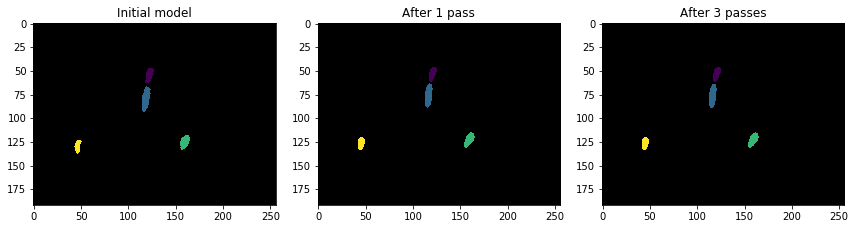

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [130]:
init_idx = 1
n_updates = 3

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])

start = time.time()
# Initialization
model = InternalModel()
identities = np.zeros(detections.shape, np.uint8)
plt.figure(figsize=(12,4))
model.initialize(rgb_stack[init_idx], measure.label(detections[init_idx], connectivity=1))
plt.subplot(131)
plt.title("Initial model")
plt.imshow(model.image, cmap=id_cmap, vmin=1)

# Iterate n_updates times through the frames to udpate the model
for n in range(n_updates):
    for i in range(len(detections)):
        identities[i] = model.match_frame(rgb_stack[i], detections[i], time_idx=i)
        model.update(rgb_stack[i], identities[i], time_idx=i)
    if n == 0:
        plt.subplot(132)
        plt.title("After 1 pass")
        plt.imshow(model.image, cmap=id_cmap, vmin=1)
print("Updating model took %d s." % (time.time() - start))

start = time.time()
# Iterate a final time to finalize the identities (without updating the model)
for i in range(len(detections)):
    identities[i] = model.match_frame(rgb_stack[i], detections[i], time_idx=i)
print("Identity matching took %d s." % (time.time() - start))
plt.subplot(133)
plt.title("After %d passes" % n_updates)
plt.imshow(model.image, cmap=id_cmap, vmin=1)
plt.tight_layout()
plt.show()

if model.overlapping_axons:
    print("Some axons are overlapping on the model's image!")

# Display resulting identities
@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(detections[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=max([axon.id for axon in model.axons]))
    plt.tight_layout()
    plt.show()

**Error detection**  
Detect tracking errors through some metrics/infos/etc.

Argmax: 0 - argmin: 24
21 frames with less than 4 ROIs


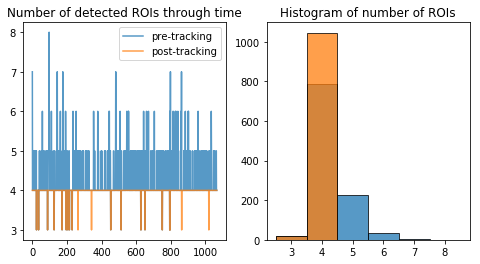

In [131]:
# Plot number of detected ROIs along time
n_roi_id = np.zeros(len(identities))
for i in range(len(n_roi)):
    n_roi_id[i] = measure.label(identities[i].astype(detections.dtype), connectivity=1, return_num=True)[1]
#     if n_roi_id[i] < 4:
#         print(i)
print("Argmax:", np.argmax(n_roi_id), "- argmin:", np.argmin(n_roi_id))
print("%d frames with less than %d ROIs" % (np.sum(n_roi_id < len(model.axons)), len(model.axons)))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(n_roi, alpha=0.75)
plt.plot(n_roi_id, alpha=0.75)
plt.legend(["pre-tracking", "post-tracking"])
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.hist(n_roi_id, bins=np.arange(n_roi_id.min(), n_roi_id.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.xticks(np.arange(n_roi_id.min(), n_roi.max() + 1))
plt.show()

In [132]:
# Look for frames where the row order of axons is violated
# Model row orders <=> rules
rules = get_rules(model.image)
print("Model rules:", rules, sep="\n")

verifs = rules_violated(rules, identities)
print("%d frames against the rules:\n" % np.sum(verifs),
      [i for i in range(len(identities)) if verifs[i]], sep="")

Model rules:
[[4 3]]
0 frames against the rules:
[]


[0.00434427 0.01258389 0.03063387 0.04770697]


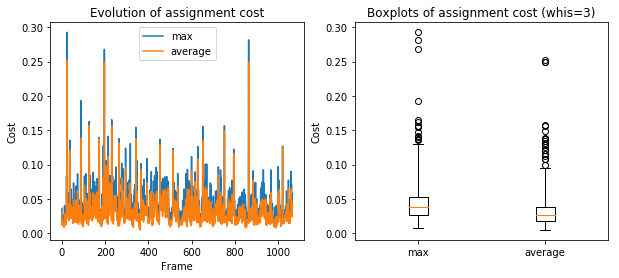

IQR 3: 15
[ 24  36  87  88 126 172 196 214 230 264 342 453 651 751 863]


In [133]:
# Compute cost of identities for each frame and look for outliers
# Compute first model's features
ids_to_idx = dict()
for i, axon in enumerate(model.axons):
    ids_to_idx.update({axon.id: i})

x_model = np.stack([axon.position for axon in model.axons], axis=0)
x_model -= x_model.mean(0)
area_model = np.array([axon.area for axon in model.axons])
area_model = area_model / area_model.mean()

# Loop over frames
cost_mean = np.zeros(len(identities))
cost_max = np.zeros(len(identities))
for i in range(len(identities)):
    regions = measure.regionprops(identities[i])
    
    # Compute frame features
    x_frame = np.array([region.centroid for region in regions])
    x_frame -= x_frame.mean(0)
    area_frame = np.array([region.area for region in regions])
    area_frame = area_frame / area_frame.mean()
    
    cost_matrix = model.match_inner_cost(x_frame, x_model, area_frame, area_model, identities.shape[1])
    cost = cost_matrix[np.arange(len(regions)), np.array([ids_to_idx[reg.label] for reg in regions])]
    if cost.size == 0:
        cost_mean[i] = np.nan
        cost_max[i] = np.nan
    else:
        cost_mean[i] = np.mean(cost)
        cost_max[i] = np.max(cost)
    if i == 121:
        print(cost)

iqr_cutoff = 3
cost_max_nanfree = cost_max[np.logical_not(np.isnan(cost_max))]
cost_mean_nanfree = cost_mean[np.logical_not(np.isnan(cost_mean))]
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plt.title("Evolution of assignment cost")
plt.plot(cost_max)
plt.plot(cost_mean)
plt.legend(["max", "average"])
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.subplot(122, sharey=ax1)
plt.title("Boxplots of assignment cost (whis={})".format(iqr_cutoff))
plt.boxplot([cost_max_nanfree, cost_mean_nanfree], whis=iqr_cutoff, labels=["max", "average"])
plt.ylabel("Cost")
plt.show()
q25, q75 = np.percentile(cost_max_nanfree, 25), np.percentile(cost_max_nanfree, 75)
iqr = q75 - q25
outliers = np.where(cost_max_nanfree > (q75 + iqr * iqr_cutoff))[0]
print("IQR {}: {}".format(iqr_cutoff, outliers.size), outliers, sep="\n")

# 4. User correction (optional)

In [144]:
indices = [146, 556 , 757,  786,  790,  894,  939, 1057]
print(indices)

old_ids = identities[indices].copy()
choice_pattern = re.compile("[0-9]+,[0-9]+")

# Plot frames and allow re-labeling
for idx in indices:
    new_id = identities[idx].copy()
    labels, num_roi = measure.label(detections[idx], connectivity=1, return_num=True)
    regions = measure.regionprops(labels)
    
    next = False
    while not next:
        clear_output()
        plt.figure(figsize=(10,10))
        plt.suptitle("Frame %d" % idx)
        plt.subplot(221)
        plt.title("Model")
        plt.imshow(model.image, cmap=id_cmap, vmin=1, vmax=len(model.axons))
        plt.subplot(222)
        plt.title("Raw input")
        plt.imshow(rgb_stack[idx])
        plt.subplot(223)
        plt.title("Regions of detection")
        plt.imshow(labels, cmap=id_cmap, vmin=1)
        plt.subplot(224)
        plt.title("Current IDs")
        plt.imshow(new_id, cmap=id_cmap, vmin=1, vmax=len(model.axons))
        plt.tight_layout()
        plt.show()
        
        choice = input("Choose region and id as 'r,id' ('n' for next): ")
        if choice == "n":
            next = True
            time.sleep(1)
            continue
        elif not choice_pattern.match(choice):
            print("Incorrect input, retry")
            time.sleep(1)
            continue
        reg, id = map(int, choice.split(","))
        
        if reg not in np.arange(num_roi) + 1:
            print("Wrong region %d" % reg)
            time.sleep(1)
            continue
        elif id not in [axon.id for axon in model.axons]:
            if id == 0: # delete current assignment
                new_id[labels == reg] = 0
            else:
                print("Wrong ID %d" % id)
            time.sleep(1)
            continue
        else:
            new_id[new_id == id] = 0
            new_id[labels == reg] = id
        
    identities[idx] = new_id.copy()
clear_output()

@interact(idx=(0, len(indices) - 1))
def plot_corrections(idx=0):
    _, n_old = measure.label(old_ids[idx], connectivity=1, return_num=True)
    _, n_corr = measure.label(identities[idx], connectivity=1, return_num=True)
    
    plt.figure(figsize=(10,10))
    plt.suptitle("Frame %d" % indices[idx])
    plt.subplot(221)
    plt.title("Model")
    plt.imshow(model.image, cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.subplot(222)
    plt.title("Raw input")
    plt.imshow(rgb_stack[indices[idx]])
    plt.subplot(223)
    plt.title("Old ID")
    plt.imshow(old_ids[idx], cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.subplot(224)
    plt.title("New ID")
    plt.imshow(identities[indices[idx]], cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

# Extract fluorescence traces
Use the identities to extract the fluorescence traces of the axons through time.

Computing traces took 31.225 s.


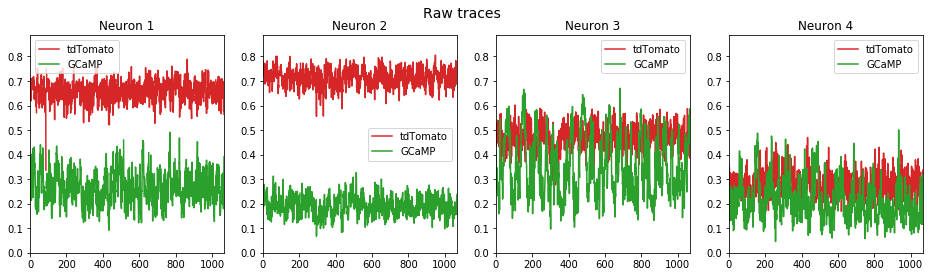

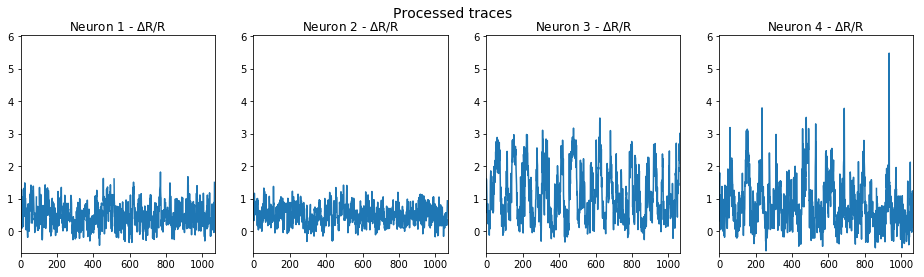

In [134]:
n_frames_0 = 10 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 15:
    print(identities.max(), "different neurons identified, traces are not computed.\n")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(rgb_stack[np.logical_not(seg_stack),0])
# bkg_g = np.mean(rgb_stack[np.logical_not(seg_stack),1])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        roi = rgb_stack[i,...][identities[i] == (j + 1)]
        if roi.size > 0:
            traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= 1.1 * bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < 1.1 * bkg: {:.3f} < {:.3f}). "
              "Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), 1.1 * bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    # If no window of n_frames_0 exists, search for smaller ones
    for j in range(1, n_frames_0):
        if not np.isinf(R_0):
            break
        R_0 = np.convolve(R_t, np.ones(n_frames_0 - j) / (n_frames_0 - j), 'valid')
        R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(dR_R[has_tdTom]) + np.isinf(dR_R[has_tdTom]), 0, dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(dR_R[np.logical_not(has_tdTom)]) + np.isinf(dR_R[np.logical_not(has_tdTom)]),
                            0, dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, ymax_R if has_tdTom[i] else ymax_F)
plt.show()

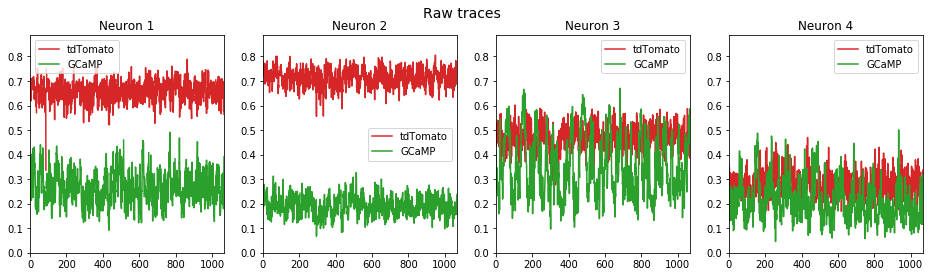

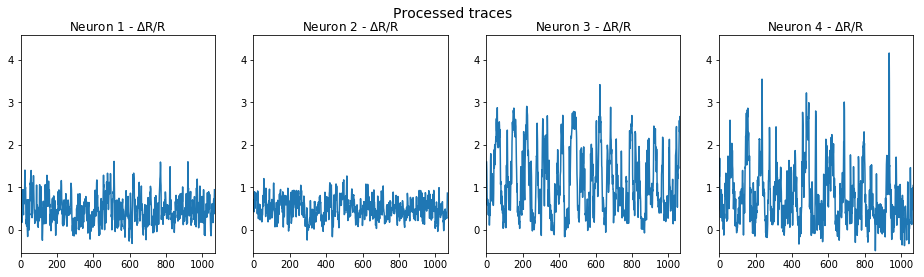

In [135]:
k = 3
new_dR_R = dR_R.copy()
for i in range(new_dR_R.shape[0]):
    for j in range(new_dR_R.shape[1]):
        new_dR_R[i, j] = np.nanmedian(dR_R[i, j-k//2:j+k//2])

N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(new_dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(new_dR_R[has_tdTom]) + np.isinf(new_dR_R[has_tdTom]), 0, 
                            new_dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(new_dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(new_dR_R[np.logical_not(has_tdTom)]) + np.isinf(new_dR_R[np.logical_not(has_tdTom)]),
                            0, new_dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(new_dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, 
             ymax_R if has_tdTom[i] else ymax_F)
plt.show()